In [1]:
import os, cv2
import tensorflow as tf
import matplotlib.pyplot as plt, numpy as np
from tensorflow import keras

from centernet import CenterNet
from data import VOCDataset
from losses import centernet_loss

In [2]:
input_shape = (512, 512)
backbone = 'resnet50'

epochs = 1
batch_size = 2
buffer_size = batch_size * 5
lr = 1e-2
freeze = True
finetune = True or freeze

data_path = "..\\..\\Centernet\\VOC2007"
train_file = "..\\..\\Centernet\\VOC2007\\ImageSets\\ceph\\train.txt"
val_file = "..\\..\\Centernet\\VOC2007\\ImageSets\\ceph\\val.txt"
test_file = "..\\..\\Centernet\\VOC2007\\ImageSets\\ceph\\test.txt"


train_dataset_raw = VOCDataset(data_path, input_shape, train_file,
                               batch_size, True)
train_dataset = train_dataset_raw.load_dataset()

val_dataset_raw = VOCDataset(data_path, input_shape, val_file,
                             batch_size, False)
val_dataset = val_dataset_raw.load_dataset()

########
test_dataset_raw = VOCDataset(data_path, input_shape, test_file,
                             batch_size, False)
test_dataset = test_dataset_raw.load_dataset()
########

vis_dataset_raw = VOCDataset(data_path, input_shape, train_file, 1, False)
vis_dataset = vis_dataset_raw.load_dataset().repeat()

steps_per_epoch = len(train_dataset_raw) // batch_size

loading the context of data_file ...: 550it [00:00, 275578.45it/s]
loading the context of data_file ...: 50it [00:00, ?it/s]
loading the context of data_file ...: 50it [00:00, 25061.57it/s]
loading the context of data_file ...: 550it [00:00, 551618.17it/s]


In [3]:
ckpt_path = './logs/test/20220525-180744/ckpt.h5'

model = CenterNet(train_dataset_raw.class_names,
                      backbone_weights='imagenet',
                      freeze=freeze,
                      finetune=finetune)

In [4]:
model.build(input_shape=(1, 512, 512, 3))

In [5]:
model.load_weights(ckpt_path)

In [17]:
model.summary()

Model: "centernet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 16, 16, 2048) 23587712    input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 16, 16, 2048) 0           resnet50[0][0]                   
__________________________________________________________________________________________________
conv2d_transpose_3 (Conv2DTrans (None, 32, 32, 256)  8388608     dropout_1[0][0]                  
__________________________________________________________________________________________

In [6]:
# prediction_result = model.predict(test_dataset)
prediction_result = model.predict(val_dataset)

In [91]:
from centernet import decode

In [92]:
hm_pred, wh_pred, reg_pred = model.predict(val_dataset)
detections_pred = decode(hm_pred, wh_pred, reg_pred, 100)

In [99]:
detections_pred[0][0]

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([4.6286678e+01, 9.0753204e+01, 6.0920025e+01, 1.0478816e+02,
       4.8935950e-02, 0.0000000e+00], dtype=float32)>

In [103]:
t = detections_pred[0]

In [104]:
t.shape

TensorShape([100, 6])

In [105]:
for topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids in t:
    print(class_ids, scores)

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.04893595, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.048631907, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.04857543, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.048397332, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.048291743, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.048240542, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.04818678, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.047982723, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.047948837, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.04776913, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.047730744, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float

In [106]:
topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids = t[0]

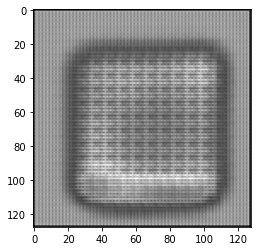

In [34]:
tmp = prediction_result[0][0]
plt.imshow(tmp[:,:,1],cmap='gray')

(128, 128)

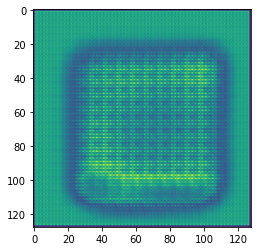

In [86]:
tmp_reduce = tmp[...,2]
plt.imshow(tmp_reduce)
tmp_reduce.shape


In [109]:
t_1 = np.array(t[0])

In [110]:
t_1

array([4.6286678e+01, 9.0753204e+01, 6.0920025e+01, 1.0478816e+02,
       4.8935950e-02, 0.0000000e+00], dtype=float32)

In [112]:
pnt_x = int((t_1[0] + t_1[2])/2)
pnt_y = int((t_1[1] + t_1[3])/2)

print(pnt_x, pnt_y)

53 97


In [88]:
tmp_reduce.shape

(128, 128)

<ipython-input-114-f6047c157339>:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(zeros, (xmin, ymin), (xmax, ymax), (0, 0, 255), 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


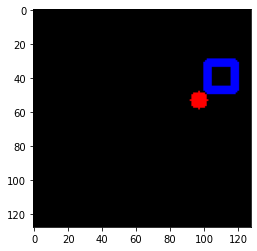

In [114]:
zeros = np.zeros((128, 128, 3))
xmin,ymin,xmax,ymax = val_dataset_raw[0][1][2]

cv2.circle(zeros, (pnt_y,pnt_x), 5, (255, 0, 0), -1)
cv2.rectangle(zeros, (xmin, ymin), (xmax, ymax), (0, 0, 255), 3)

plt.imshow(zeros)

---

In [7]:
val_dataset_raw = VOCDataset(data_path, input_shape, val_file,
                             1, False)
val_dataset = val_dataset_raw.load_dataset()

loading the context of data_file ...: 50it [00:00, 50111.16it/s]


In [8]:
a = model.predict(val_dataset)

In [21]:
from centernet import decode, img_vis

detections_pred = decode(a[0], a[1], a[2], 100)

In [179]:
y = val_dataset.take(1)
next(y)

TypeError: 'TakeDataset' object is not an iterator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


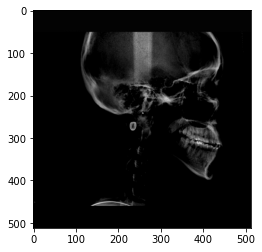

In [22]:
plt.imshow(val_dataset_raw[0][0])

### 해야 할 일

1. TakeDataset이 뭔지
2. MapDataset이 뭔지
3. img_vis 함수가 뭔지
3. centernet.py 파일 분석하기

In [31]:
# img_vis(images, boxes, cls_ids, reg_masks, detections, colors, class_names)
#t = val_dataset
import importlib
import centernet as ct
importlib.reload(ct)
t = val_dataset_raw[0]
t_result = ct.img_vis([t[0]],[t[1]],[t[2]],[t[6]], detections_pred, [(255, 0, 0),(0,255,0),(0,0,255)], ['Glabella', 'R3', 'Nasion'])

<class 'numpy.ndarray'>
[0.09222311 0.09154192 0.09138206 0.08985832 0.08972725 0.08920571
 0.08854941 0.08846712 0.08844885 0.08832279 0.08780912 0.0869585
 0.08657652 0.08599743 0.08569524 0.08567324 0.08518034 0.08513319
 0.08445358 0.08437237 0.08430654 0.0838013  0.08379325 0.08353874
 0.08310199 0.08282426 0.08250788 0.08248916 0.08239615 0.08220974
 0.08164287 0.08152315 0.0812746  0.08120194 0.08087593 0.0807586
 0.080744   0.08069009 0.07999671 0.07991683 0.07975814 0.07941341
 0.07920495 0.07912239 0.07897556 0.07870033 0.07862085 0.07853508
 0.07840824 0.07827869 0.07822272 0.07816467 0.07810253 0.07792503
 0.07791355 0.07759753 0.07756436 0.07754886 0.07735094 0.07727984
 0.07701898 0.07695299 0.07692686 0.07682663 0.07677385 0.07661372
 0.07657889 0.0763216  0.07604751 0.07579905 0.07577786 0.0756695
 0.07546851 0.07523152 0.0751535  0.07514453 0.07505646 0.07502609
 0.0750185  0.0749917  0.07477131 0.07474616 0.07471946 0.07466108
 0.07463777 0.07449517 0.07448679 0.07441

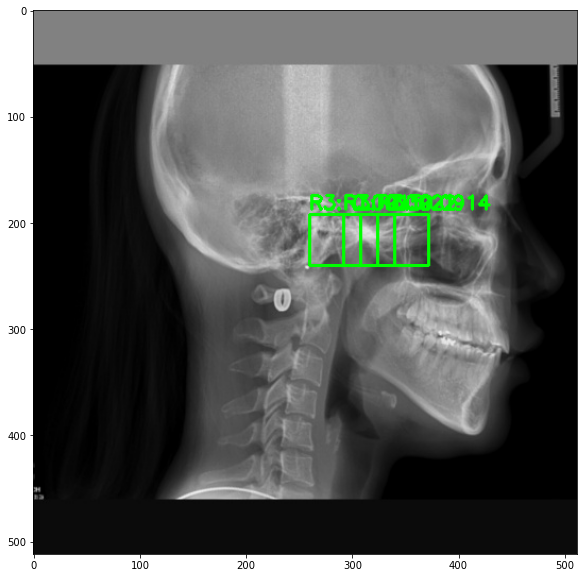

In [32]:
plt.figure(figsize=(10, 10))

plt.imshow(t_result)

In [13]:
detections_pred[0]

<tf.Tensor: shape=(100, 6), dtype=float32, numpy=
array([[7.37992554e+01, 4.85928345e+01, 8.52030945e+01, 6.04178848e+01,
        9.22231078e-02, 1.00000000e+00],
       [6.59569321e+01, 4.87440948e+01, 7.70454178e+01, 6.02666245e+01,
        9.15419161e-02, 1.00000000e+00],
       [8.17595520e+01, 4.85527916e+01, 9.32427979e+01, 6.04579277e+01,
        9.13820565e-02, 1.00000000e+00],
       [8.17211075e+01, 4.05125694e+01, 9.32812424e+01, 5.24981499e+01,
        8.98583233e-02, 1.00000000e+00],
       [5.79233093e+01, 5.67072792e+01, 6.90790405e+01, 6.83034363e+01,
        8.97272527e-02, 1.00000000e+00],
       [5.77903748e+01, 6.45769806e+01, 6.92119751e+01, 7.64337311e+01,
        8.92057121e-02, 1.00000000e+00],
       [6.57611694e+01, 5.65454254e+01, 7.72411804e+01, 6.84652939e+01,
        8.85494053e-02, 1.00000000e+00],
       [6.92053528e+01, 4.59911232e+01, 8.17969971e+01, 5.90195961e+01,
        8.84671211e-02, 1.00000000e+00],
       [5.77770348e+01, 4.85630684e+01, 6.9225

In [77]:
xmin,ymin,xmax,ymax = val_dataset_raw[0][1][0]

In [21]:
print(np.min(prediction_result[0][0]))
print(np.max(prediction_result[0][0]))

0.0021168888
0.04893595


In [23]:
for i in range(50):
    print(np.max(prediction_result[0][i]))

0.04893595
0.049131244
0.04938066
0.04880938
0.049564064
0.048732936
0.0494231
0.049315184
0.04904428
0.049181044
0.050605267
0.04885328
0.049214244
0.049567282
0.049256414
0.05007693
0.048960418
0.04883936
0.04972467
0.050315082
0.048945516
0.050454944
0.04963571
0.049681008
0.049430966
0.049264133
0.049200118
0.049012035
0.049401373
0.050305724
0.049681008
0.049430966
0.049264193
0.049200118
0.049012035
0.049401373
0.049046665
0.04976198
0.049195707
0.048960596
0.049494
0.048667192
0.050172865
0.049965918
0.049137294
0.049749672
0.049545288
0.050007284
0.049406707
0.04945299
